In [1]:
import numpy as np;
import matplotlib.pyplot as plt
import os.path as osp
from sklearn.model_selection import train_test_split

numBin = 23
minPts = 10

### EDGE
calcolo dei valori massimi e minimi di ogni feature dei dati presenti in ogni dispositivo per poi inviare il risultato al cloud

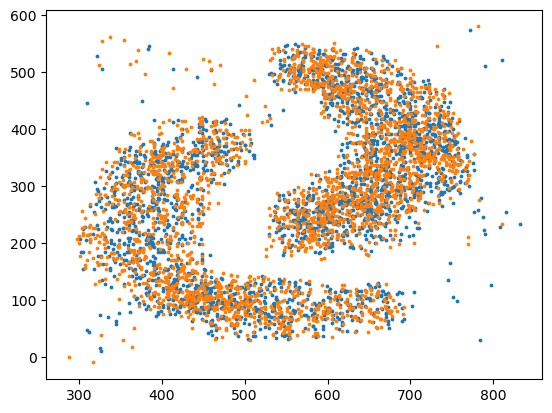

(array([301,  11]), array([832, 573]))

In [2]:
def width(X):
    min = X.min(axis = 0)
    max = X.max(axis = 0)
    return (min,max)
    
path = osp.dirname(osp.realpath("__file__"))
#caricamento dati di test
data = np.loadtxt(path+'\data3.csv',delimiter=",", dtype=int)

x1,x2,y1,y2 = train_test_split(data[:,:-1],data[:,-1], test_size=0.5, random_state=42)

#calcolo valori di massimi e minimi locali
w1 = width(x1)
w2 = width(x2)

#plot dei dati
plt.scatter(x1[:,0], x1[:,1], s=3)
plt.scatter(x2[:,0], x2[:,1], s=3)
plt.show()
#send w to cloud
w1

### CLOUD
aggregazione dei valori ricevuti al fine di calcolare i valori min e max rispetto a tutti i dati in modo da generare una griglia comune per tutti i dispositivi

In [3]:
minTot = np.vstack([w1[0],w2[0]]).min(axis = 0) - 0.01
maxTot = np.vstack([w1[1],w2[1]]).max(axis = 0) + 0.01
#send to edge

### EDGE
Discretizzazione ed aggregazione dei dati rispetto ad una griglia avente una dimensione fissa pari a numBin.
Il risultato sarà una matrice avente un numero di colonne pari al numero di feature +1. L'ultima colonna rappresenta il numero totale di elementi presenti nella cella.

In [4]:
#discretizzazione dei valori rispetto al numero di bin prefissato
def minMaxBinner(X,min,max,numBin):
    n = X.shape[0]
    width=np.abs(max-min)/numBin
    res = (X - min) / width
    res = np.c_[res,np.ones(n,int)].astype(int)
    return res

#aggregazione dei dati corrispondenti alla stessa cella
def aggregation(X,numBin):    
    for i in range(numBin**X.shape[1]):
        index = np.array([],int)
        for j in range(i+1,X.shape[0]):
            if(np.array_equal(X[i][:-1],X[j][:-1])):
                X[i][-1]+=X[j][-1]
                index = np.append(index, j)
        X = np.delete(X,index,axis = 0)

    return X

disc1 = minMaxBinner(x1, minTot, maxTot, numBin)
edge1 = aggregation(disc1,numBin)    

disc2 = minMaxBinner(x2, minTot, maxTot, numBin)
edge2 = aggregation(disc2,numBin)  

#send to cloud

array([[18, 15, 17],
       [16,  4, 11],
       [11,  4, 10],
       [14, 11, 25],
       [ 3, 13, 13],
       [ 8,  3, 13],
       [ 1, 11,  7],
       [ 3,  6, 10],
       [12, 19, 21],
       [14, 19, 21],
       [19, 17,  4],
       [ 3, 12, 15],
       [ 3, 11, 10],
       [ 7,  4, 26],
       [ 4, 11, 20],
       [ 6,  5, 19],
       [10, 11,  4],
       [13, 17, 10],
       [19, 14, 22],
       [ 5, 10,  9],
       [ 4,  3,  7],
       [10,  7,  2],
       [15, 18, 20],
       [18, 12, 15],
       [11,  7,  3],
       [18, 18,  6],
       [13,  9, 25],
       [13, 10, 24],
       [13, 20, 18],
       [15, 15, 17],
       [14, 13,  9],
       [ 4, 10, 12],
       [19, 15, 14],
       [16, 12, 18],
       [14,  7,  3],
       [18, 13,  8],
       [ 4,  8, 18],
       [17,  2,  1],
       [18, 10,  3],
       [10,  8,  5],
       [16, 16, 15],
       [10,  1,  5],
       [14, 16, 10],
       [ 7,  5, 10],
       [13,  8, 13],
       [ 8, 14,  4],
       [13, 12,  8],
       [12, 1

questo approccio permette di ottenere una discreta riduzione dei dati,da $$numElementi*numFeature$$ si passa ad un upper bound pari a $$(numBin^{numFeature}) * numFeature+1$$

### CLOUD

In [5]:
#Calcolo degli indici delle celle vicine
def neighborhood(X,el):
    index = np.array([],int)
    for i,n in enumerate(X):
        diff = el[:-2]-n[:-2]
        ok = True
        for j in np.abs(diff):
            if j>1:
                ok = False
        if ok:
            index = np.append(index,i)
    return index

#aloritmo realizzato prendendo spunto dal DBSCAN originale
def DBSCAN(X,numBin,minPts):
    X = aggregation(X, numBin)
    X = np.c_[X,np.zeros(X.shape[0],int)].astype(int)
    c = 0
    for el in X:
        if el[-1]!=0: continue
        if el[-2]<minPts:
            el[-1] = -1
            continue
        c+=1
        el[-1] = c
        n = neighborhood(X,el)  
        k=-1
        while True:
            k+=1
            if k>=n.size: break
            if X[n[k]][-1]==-1: X[n[k]][-1] = c
            if X[n[k]][-1]!=0: continue
            X[n[k]][-1] = c
            if X[n[k]][-2]<minPts:continue
            n2 = neighborhood(X,X[n[k]])
            #n = np.concatenate((n,n2))
            for neighbor in n2:
                if neighbor not in n:
                    n = np.append(n, neighbor)
        
    #rimozione delle celle associate ad anomalie
    index = np.array([],int)
    for i,el in enumerate(X):
        if el[-1]==-1:
            index = np.append(index,i)
    X = np.delete(X,index,axis = 0)
    #costruzione di un dizionario key:value dove la chiave è data dalla cella e il valore è dato dal numero di cluster
    x_tuple=list(map(tuple,X[:,:-2]))
    x_dict=dict(zip(x_tuple,X[:,-1]))
    return x_dict


#unione dei dati aggregati forniti dai dispositivi edge
data = np.concatenate((edge1,edge2),axis = 0)
#calcolo dei cluster
cluster_dict = DBSCAN(data,numBin,minPts)
#send to edge

### EDGE

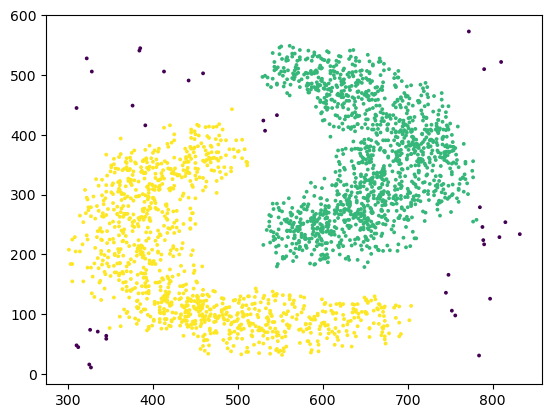

In [6]:
# associazione dei cluster ai dati originali utilizzando i dati discretizzati come valore chiave nel dizionario
y1_pred = [ cluster_dict.get(tuple(i[:-1]),-1) for i in disc1 ]

scatter = plt.scatter(x1[:,0], x1[:,1], c = y1_pred, s=3)

In [7]:
from sklearn import metrics

print(f"Homogeneity: {metrics.homogeneity_score(y1, y1_pred):.3f}")
print(f"Completeness: {metrics.completeness_score(y1, y1_pred):.3f}")
print(f"V-measure: {metrics.v_measure_score(y1, y1_pred):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(y1, y1_pred):.3f}")
print(f"Adjusted Mutual Information: {metrics.adjusted_mutual_info_score(y1, y1_pred):.3f}")
print(f"Silhouette Coefficient: {metrics.silhouette_score(x1, y1_pred):.3f}")

Homogeneity: 0.973
Completeness: 0.983
V-measure: 0.978
Adjusted Rand Index: 0.994
Adjusted Mutual Information: 0.978
Silhouette Coefficient: 0.437


array([0, 1, 1, ..., 0, 0, 1], dtype=int64)

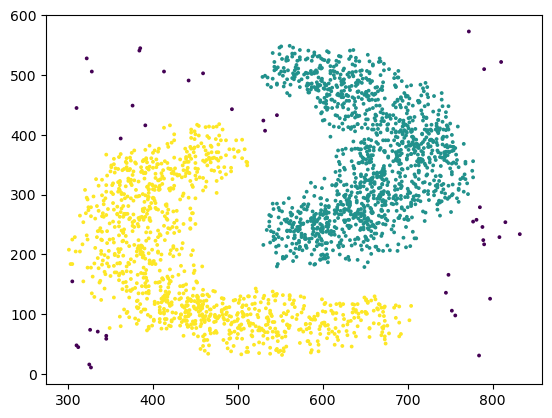

In [8]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=25, min_samples=10).fit(x1)
y1_sklearn = db.labels_


scatter = plt.scatter(x1[:,0], x1[:,1], c = y1_sklearn , s=3)

y1_sklearn

In [9]:
print(f"Homogeneity: {metrics.homogeneity_score(y1, y1_sklearn):.3f}")
print(f"Completeness: {metrics.completeness_score(y1, y1_sklearn):.3f}")
print(f"V-measure: {metrics.v_measure_score(y1, y1_sklearn):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(y1, y1_sklearn):.3f}")
print(f"Adjusted Mutual Information: {metrics.adjusted_mutual_info_score(y1, y1_sklearn):.3f}")
print(f"Silhouette Coefficient: {metrics.silhouette_score(x1, y1_sklearn):.3f}")

Homogeneity: 0.980
Completeness: 0.982
V-measure: 0.981
Adjusted Rand Index: 0.995
Adjusted Mutual Information: 0.981
Silhouette Coefficient: 0.432
